In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=None
pd.options.display.max_rows=None

# load train and test data sets
X = pd.read_csv('./input/train.csv')
X_test = pd.read_csv('./input/test.csv')

# remove data with missing target values, separate targets from predictors
X.dropna(subset=['SalePrice'],inplace=True)
y = X.SalePrice
X.drop('SalePrice',axis=1,inplace=True)

exclude_cols=['MiscFeature','PoolQC','Alley']
X.drop(exclude_cols,axis=1,inplace=True)
X_test.drop(exclude_cols,axis=1,inplace=True)

# list numeric and categorical columns
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

# categorical columns safe for encoding
good_cat_columns = [col for col in categorical_cols if set(X_train[col].unique())==set(X_valid[col].unique())]
bad_cat_columns = list(set(categorical_cols)-set(good_cat_columns))

X_train.drop(bad_cat_columns, axis=1, inplace=True)
X_valid.drop(bad_cat_columns, axis=1, inplace=True)
X_test.drop(bad_cat_columns, axis=1, inplace=True)

# low and high cardinality categorical columns
low_cardinality_cols = [col for col in good_cat_columns if X[col].nunique() < 10]
high_cardinality_cols = list(set(good_cat_columns)-set(low_cardinality_cols))

In [76]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def get_scores(n_estimators):
    # preprocessing of numerical columns
    numerical_transformer = SimpleImputer(strategy='median')

    # preprocessing of low cardinality columns
    OH_transformer = Pipeline(steps=[
        ('imputation',SimpleImputer(strategy='constant')),
        ('one_hot_encoding',OneHotEncoder(handle_unknown='ignore'))
    ])

    # preprocessing of high_cardinality columns
    Label_transformer = Pipeline(steps=[
        ('imputation',SimpleImputer(strategy='constant')),
        ('label_encoding',LabelEncoder())
    ])

    # bundle preprocessing of numerical and categorical columns
    preprocessor = ColumnTransformer(transformers=[
        ('num',numerical_transformer,numerical_cols),
        ('oh',OH_transformer,low_cardinality_cols),
        ('lbl',Label_transformer,high_cardinality_cols)
    ])

    # define model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=0.05, random_state=0, 
                         subsample=0.8, objective='reg:squarederror', max_depth=6)

    # bundle preprocessing and modeling code
    clf = Pipeline(steps=[
        ('preprocessing',preprocessor),
        ('model',model)
    ])
    
    scores = -1 * cross_val_score(clf,X,y,cv=5,scoring='neg_mean_absolute_error')
    print(scores)
    return scores.mean()

In [77]:
number_of_estimators=[50, 100, 150, 200, 250, 300, 350, 400, 450, ]
# number_of_estimators=[250, 300, 350, 400, 450, 500, 550, 600]
results = {n:get_scores(n) for n in number_of_estimators}

[22210.85621789 20910.033872   23910.72661601 18134.7287698
 23506.29890839]
[16335.98959225 16351.20466342 16855.79324968 14248.44741278
 17242.75334439]
[16017.04947025 16306.41721961 16684.63720034 14078.85429152
 16563.99446169]
[15909.63944777 16256.22056935 16645.69396137 13993.94564694
 16354.80233305]
[15846.37363549 16268.79612586 16738.59194403 13958.07780394
 16294.53042059]
[15834.92826948 16212.51513003 16764.33682042 13900.24549176
 16304.24261558]
[15879.27828018 16229.02968482 16820.85625803 13879.22788688
 16265.11964897]
[15886.27030715 16223.20608144 16836.19214202 13864.19075075
 16248.34701413]
[15897.68899829 16219.02173855 16881.38619702 13858.51598619
 16267.41834332]


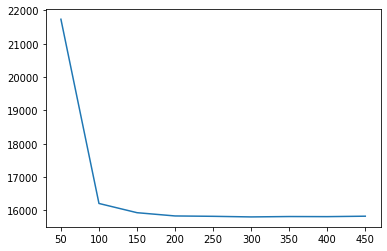

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [79]:
for k in results:
    print(k,results[k])

50 21734.52887681935
100 16206.83765250428
150 15930.190528681507
200 15832.060391695204
250 15821.273985980308
300 15803.253665453765
350 15814.70235177654
400 15811.641259096747
450 15824.806252675515


In [ ]:
clf.fit(X_train,y_train)

In [4]:
preds = clf.predict(X_valid)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_valid,preds)

16826.433473351884

In [5]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index+1461,
                       'SalePrice': preds})
output.to_csv('submission.csv', index=False)

ValueError: arrays must all be same length

In [ ]:
[(col,X[col].isnull().sum()) for col in X.columns if X[col].isnull().any()]

In [37]:
?XGBRegressor

Init signature:
XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    missing=None,
    importance_type='gain',
    **kwargs,
)
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.

Parameters
----------
max_depth : int
    Maximum tree depth for base learners.
learning_rate : float
    Boosting learning rate (xgb's "eta")
n_estimators : int
    Number of trees to fit.
verbosity : int
    The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
silent : boolean
    Whether to print messages while running boosting. Deprecated. Use verbosity instead.
objec